## Langevin dynamics experiment
A small module to run a naive implementation of Langevin dynamics. Currently $N=100$ is pretty small, but the size of the tensor is the main constraint. 
An **important note** is that the Mannelli paper doesn't actually explicitly run Langevin dynamics. They instead run the Langevin State Evolution (LSE) equations, which are an analytic solution for average correlations (either autocorrelations or correlation with the signal) of the Langevin state as a function of time. It would be nice to verify that their results are robust against theory, but it may prove computationally intractable for the large $N$ needed for their results to hold. 

In [52]:
import numpy as np
import math
from tqdm import tqdm
import matplotlib.pyplot as plt

In [53]:
def generate_spiked_data(N, p, delta2, deltap, seed=None):
    if seed is not None:
        np.random.seed(seed)

    x_star = np.random.randn(N)
    x_star /= np.linalg.norm(x_star)
    x_star *= np.sqrt(N)

    noise_matrix = np.random.normal(0, delta2, size=(N, N))
    noise_matrix = np.triu(noise_matrix, 1)
    noise_matrix += noise_matrix.T
    Y = (np.outer(x_star, x_star) / np.sqrt(N)) + noise_matrix
    np.fill_diagonal(Y, 0.0)

    if p != 3:
        raise ValueError("only p = 3 rn")

    T = np.zeros((N, N, N))
    for i in range(N):
        for j in range(i+1, N):
            for k in range(j+1, N):
                signal = x_star[i] * x_star[j] * x_star[k]
                noise = np.random.normal(0, deltap)
                val = (np.sqrt(2) / N) * signal + noise
                T[i, j, k] = val
                T[i, k, j] = val
                T[j, i, k] = val
                T[j, k, i] = val
                T[k, i, j] = val
                T[k, j, i] = val

    return x_star, Y, T

def langevin_dynamics_projected(x0, Y, T, delta2, deltap, p, steps, step_size, seed=None):
    if seed is not None:
        np.random.seed(seed)

    if p != 3:
        raise ValueError("only p = 3 rn")

    N = x0.shape[0]
    x = x0.copy()
    traj = [x.copy()]

    for _ in tqdm(range(steps), desc="Langevin algorithm progress", unit='step'):
        grad_matrix = -1 / delta2 * (Y @ x) / np.sqrt(N)

        grad_tensor = np.einsum('ijk,j,k->i', T, x, x)
        grad_tensor += np.einsum('ijk,i,k->j', T, x, x)
        grad_tensor += np.einsum('ijk,i,j->k', T, x, x)
        grad_tensor *= -1 / deltap

        grad = grad_matrix + grad_tensor

        noise = np.random.normal(0, 1, size=N)
        x = x - step_size * grad + np.sqrt(2 * step_size) * noise
        x = np.sqrt(N) * x / np.linalg.norm(x)

        traj.append(x.copy())

    return np.array(traj)


In [33]:
from tqdm import tqdm

def langevin_dynamics_projected(x0, Y, T, delta2, deltap, p, steps, step_size, seed=None):
    """
    Run Langevin dynamics on the sphere using projection to enforce the constraint.

    Args:
        x0 (np.ndarray): Initial vector of shape (N,), assumed to have norm sqrt(N).
        Y (np.ndarray): Spiked matrix of shape (N, N).
        T (np.ndarray): Spiked tensor of shape (N,)*p.
        delta2 (float): Noise variance for the matrix.
        deltap (float): Noise variance for the tensor.
        p (int): Tensor order.
        steps (int): Number of Langevin steps.
        step_size (float): Step size (epsilon).
        seed (int, optional): Random seed.

    Returns:
        traj (np.ndarray): Array of shape (steps+1, N) with Langevin trajectory.
    """
    if seed is not None:
        np.random.seed(seed)

    N = x0.shape[0]
    x = x0.copy()
    traj = [x.copy()]

    for _ in tqdm(range(steps), desc="Langevin progress"):
        # Gradient of matrix term: -1/Delta2 * Y @ x / sqrt(N)
        grad_matrix = -1 / delta2 * (Y @ x) / np.sqrt(N)

        # Gradient of tensor term: -1/Delta_p * contraction
        grad_tensor = np.zeros_like(x)
        for i in range(N):
            slices = [slice(None)] * p
            for idx in range(p):
                slices[idx] = i
                grad_tensor[i] -= np.sum(T[tuple(slices)] * np.prod([x[j] for j in range(N) if j != i]))
                slices[idx] = slice(None)  # reset
        grad_tensor *= np.sqrt(math.factorial(p - 1)) / (deltap * N**((p - 1)/2))

        grad = grad_matrix + grad_tensor

        # Langevin update with noise
        noise = np.random.normal(0, 1, size=N)
        x = x - step_size * grad + np.sqrt(2 * step_size) * noise

        # Project back to the sphere
        x = np.sqrt(N) * x / np.linalg.norm(x)

        traj.append(x.copy())

    return np.array(traj)


### Do one trial

In [50]:
# trial
N = 100 # dimensionality
p = 3 # rank of tensor
deltap = 1.8
delta2 = 0.7

x_star, Y, T = generate_spiked_data(N, p, delta2=delta2, deltap=deltap, seed=42)

x_0 = np.random.randn(N)
x_0 /= np.linalg.norm(x_0) 
x_0 *= np.sqrt(N)

traj = langevin_dynamics_projected(x_0, Y, T, delta2=delta2, deltap=deltap, p=p, steps=1000, step_size=0.01, seed=42)

Langevin progress: 100%|██████████| 1000/1000 [00:10<00:00, 92.75it/s]


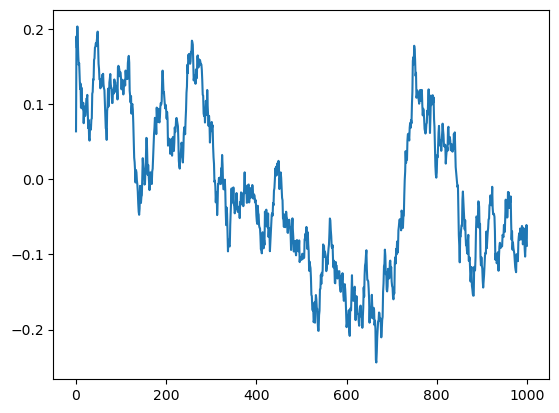

In [51]:
corr = 1/N * (traj @ x_star)
plt.plot(corr)

In [ ]:
# Parameters
N = 100
p = 3
delta2 = 0.7
deltap_list = [1.8, 1.4, 1.1, 0.64]
n_seeds = 10
steps = 1000
step_size = 0.01

avg_corrs = {}

for deltap in deltap_list:
    all_corrs = []
    print(f"Running for Δp = {deltap}")
    for seed in range(n_seeds):
        x_star, Y, T = generate_spiked_data(N, p, delta2=delta2, deltap=deltap, seed=seed)

        x_0 = np.random.randn(N)
        x_0 /= np.linalg.norm(x_0)
        x_0 *= np.sqrt(N)

        traj = langevin_dynamics_projected(x_0, Y, T, delta2=delta2, deltap=deltap, p=p,
                                           steps=steps, step_size=step_size, seed=seed)

        corr = (traj @ x_star) / N
        all_corrs.append(corr)

    avg_corr = np.mean(all_corrs, axis=0)
    avg_corrs[deltap] = avg_corr



Running for Δp = 1.8


Langevin algorithm progress: 100%|██████████| 1000/1000 [00:03<00:00, 317.64step/s]


Running for Δp = 1.4


Langevin algorithm progress: 100%|██████████| 1000/1000 [00:03<00:00, 317.06step/s]


Running for Δp = 1.1


Langevin algorithm progress: 100%|██████████| 1000/1000 [00:03<00:00, 299.42step/s]


Running for Δp = 0.64


Langevin algorithm progress: 100%|██████████| 1000/1000 [00:03<00:00, 266.52step/s]


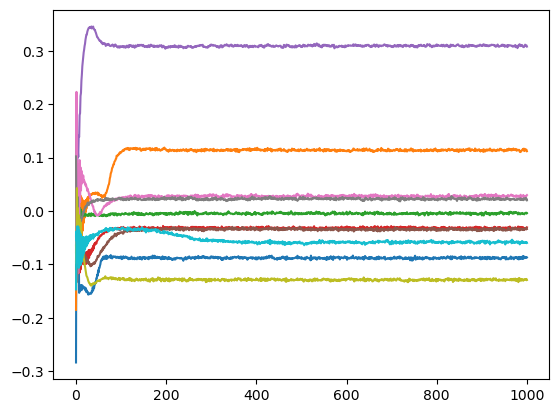

In [58]:
for i in range(len(all_corrs)):
    plt.plot(all_corrs[i], label=f"Seed {i+1}")

Different seeded realizations have vastly different $\bar{C}(t)$ curves. Sensitivity to step size? Thermal noise $\eta$? 

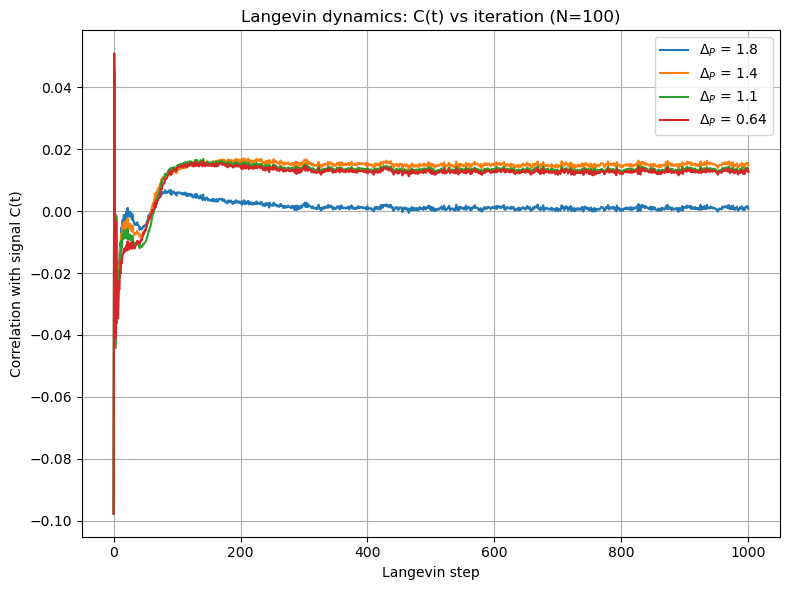

In [56]:
plt.figure(figsize=(8, 6))
for deltap, corr in avg_corrs.items():
    plt.plot(corr, label=fr'$\Delta_P$ = {deltap}')
plt.xlabel("Langevin step")
plt.ylabel("Correlation with signal C(t)")
plt.title("Langevin dynamics: C(t) vs iteration (N=100)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
